In [1]:
#from __future__ import absolute_import
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--name "rec_cuenta" --master yarn --conf spark.executor.memory=3G --conf spark.executor.cores=1 --conf spark.executor.instances=32 pyspark-shell' 


import sys
#!{sys.executable} -m pip install gcsfs
#!{sys.executable} -m pip install pyspark_dist_explore
#!{sys.executable} -m pip install findspark
#!{sys.executable} -m pip install jupyter

In [2]:
#import pyspark
#from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql import Row
#from pyspark.conf import SparkConf 
from pyspark import SparkConf, SparkContext
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime


from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql.functions import explode, col, collect_set, udf
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType, StructType, StructField, DoubleType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from datetime import datetime
from pyspark.mllib.evaluation import MulticlassMetrics, RankingMetrics, BinaryClassificationMetrics

In [3]:
#from pyspark.sql import SparkSession


sc.getConf().toDebugString()

'spark.app.id=application_1551903967241_0175\nspark.app.name=pyspark-shell\nspark.driver.appUIAddress=http://dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal:4040\nspark.driver.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.driver.host=dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal\nspark.driver.maxResultSize=1920m\nspark.driver.memory=3840m\nspark.driver.port=38095\nspark.dynamicAllocation.enabled=true\nspark.dynamicAllocation.maxExecutors=10000\nspark.dynamicAllocation.minExecutors=1\nspark.eventLog.dir=hdfs://dprc-mkt-tensorflow-tony-jupyter-m/user/spark/eventlog\nspark.eventLog.enabled=true\nspark.executor.cores=1\nspark.executor.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.executor.id=driver\nspark.executor.instances=32\nspark.executor

# parametros para validación cruzada

In [4]:
alpha_list =[30.0,  50.0, 70.0]
rank_list =[20, 100, 200]
maxIter_list =[4]
regParam_list =[0.1, 1,50,100,400]
k_folds=5
n_items=50
training_split=0.8
validation_split=0.2

#alpha_list =[1.0]
#rank_list =[4,10]
#maxIter_list =[4]
#regParam_list =[0.9]
#k_folds=2
#n_items=5


           

## Creación de rutas para leer data, guardar diccionarios y guardar ouputs

In [5]:
# reading from bucket
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
print(bucket)
todays_date = '2019_02_18_13_39_11' #'2019_02_15_19_01_20'
bucket_name = "datasets_prueba"
datafr_name = "local"
bucket_path = "gs://{}/{}/{}/{}".format(bucket, bucket_name, datafr_name, todays_date)
print(bucket_path)


bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
bucket_name_subfolder = "research"
datafr_name = "codigo_cuenta_rec"
training_folder_name="training_continuo_TF_IDF"
testing_folder_name="testing_continuo_TF_IDF"
eval_folder_name="eval_continuo_TF_IDF"

path_rating_training_TF_IDF_continuo = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,training_folder_name)
path_rating_testing_TF_IDF_continuo = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,testing_folder_name)
path_rating_eval_TF_IDF_continuo = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,eval_folder_name)

print(path_rating_training_TF_IDF_continuo)
print(path_rating_testing_TF_IDF_continuo)
print(path_rating_eval_TF_IDF_continuo)
#"gs://pry_spsa/research/codigo_cuenta_rec/output_tf_idf_continuo/"

pry_spsa
gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11
gs://pry_spsa/research/codigo_cuenta_rec/training_continuo_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/testing_continuo_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/eval_continuo_TF_IDF/


In [6]:
# ruta para guardar el pipeline y la grilla
file_name = "scripts"
type_file = "recomendacion"
typo_recomendacion= "codigo_cuenta"
typo_output= "grilla_CV_tf_idf_continuo"
path_binary_pipeline_cv_codigo_cuenta = "gs://{}/{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, file_name, type_file, typo_recomendacion)
#path_binary_pipeline_cv_codigo_cuenta
path_binary_pipeline_cv_codigo_cuenta_grilla = "gs://{}/{}/{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, file_name, type_file, typo_recomendacion, typo_output)
print(path_binary_pipeline_cv_codigo_cuenta_grilla)


gs://pry_spsa/research/scripts/recomendacion/codigo_cuenta/grilla_CV_tf_idf_continuo/


In [7]:
## Leemos los datos que previamente fueron preparados


ratings_train_tf_idf=spark.read.parquet(path_rating_training_TF_IDF_continuo)
ratings_test_tf_idf=spark.read.parquet(path_rating_testing_TF_IDF_continuo)
ratings_eval_tf_idf=spark.read.parquet(path_rating_eval_TF_IDF_continuo)

#ratings_test=ratings_test.sort(col('rating').desc())
ratings_df= ratings_train_tf_idf.union(ratings_test_tf_idf.union(ratings_eval_tf_idf))


#Building train and validation test sets
ratings_train, ratings_test = ratings_df.randomSplit([training_split, validation_split], seed = 0)



ratings_train.schema
ratings_test.show()

+------+------+---------+
|userId|itemId|   rating|
+------+------+---------+
|    45|    22|3.7592769|
|    45|   111| 4.659592|
|    45|   195|2.4301615|
|    45|   719| 3.504332|
|    45|   720| 2.430509|
|    45|   759|3.2114074|
|    45|   767| 3.409787|
|    45|   794| 2.130287|
|    45|   855|3.1833658|
|    45|   888|3.9236612|
|    45|   908|3.1030357|
|    45|  1629|2.3457232|
|    45|  1850|4.7739897|
|    45|  1937|0.7779175|
|    45|  2129|2.1591418|
|    45|  2269|3.8680859|
|    45|  2451|2.8377488|
|    45|  3519|4.6298914|
|    45|  4437|3.9019268|
|    45|  5858|4.0931096|
+------+------+---------+
only showing top 20 rows



## creación de pipeline con Cross Validation

In [8]:
# Vamos a filtrar todos los itemId que no fueron usados en el entrenamiento.

#ratings_train_tf_idf.createOrReplaceTempView('ratings_train_tf_idf')
#ratings_test_tf_idf.createOrReplaceTempView('ratings_test_tf_idf')

#query_filtro ='''select a.* 
 #                from ratings_test_tf_idf a 
  #               where a.itemId in (select distinct itemId from ratings_train_tf_idf)'''

#ratings_test_tf_idf2=spark.sql(query_filtro)

#ratings_test_tf_idf2.show()

In [9]:

#    rank = la cantidad de factores latentes en el modelo (4,  50 , 100, 150, 200 como valores seleccionados)
#    maxIter = el número máximo de iteraciones (valor predeterminado)
#    regParam = el parámetro de regularización (0.1, 0.05 y 0.01 como valores seleccionados)
#    alpha: Refleja cuanto valoramos los eventos observados versus los no observados
#    https://amsterdam.luminis.eu/2016/12/04/alternating-least-squares-implicit-feedback-search-alpha/
#    iteration
#ratings_train2 = ratings_train.withColumnRenamed("rating", "label")


initial_date = datetime.strftime(datetime.today(), "%Y_%m_%d_%H_%M_%S")
print(initial_date)


als_continuo= ALS(userCol="userId", itemCol="itemId", ratingCol="rating", coldStartStrategy="drop", implicitPrefs=True, seed=25)


pipeline_continuo = Pipeline(stages=[als_continuo])
# Diseña la grilla de parametros a probar

#paramGrid= ParamGridBuilder().addGrid(als_continuo.rank, [4]).build()

         
            
paramGrid = ParamGridBuilder()\
            .addGrid(als_continuo.rank, rank_list)\
            .addGrid(als_continuo.regParam, regParam_list)\
            .addGrid(als_continuo.alpha, alpha_list)\
            .addGrid(als_continuo.maxIter, maxIter_list)\
            .build()
           ##.addGrid(als_implicit.rank, [50]).build()
# Set evaluator
## usamos el evaluador ninario que se encuentra en la librería pyspar.ml.evaluation
# http://spark.apache.org/docs/2.4.0/api/python/_modules/pyspark/ml/evaluation.html

modelEvaluator_reg = RegressionEvaluator(predictionCol="prediction", labelCol="rating", metricName="rmse")
                
#modelEvaluator = BinaryClassificationEvaluator( rawPredictionCol='features', labelCol="rating", metricName="areaUnderPR")

crossval_reg = CrossValidator(estimator=pipeline_continuo,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator_reg,
                          numFolds=k_folds)



# Perform cross-validation


cvModel_reg = crossval_reg.fit(ratings_train)

# instanciamos al stage 0 dado que tenemos una etapa (en el binario teniamos dos etapas 1 vecassembler y als)
best_als_model_reg = cvModel_reg.bestModel.stages[0]



2019_04_10_22_20_58


In [10]:
#zip(cvModel_reg.avgMetrics, paramGrid)




print("Best number of latent factors (rank parameter): " + str(best_als_model_reg._java_obj.parent().getRank()))
print("Best value of regularization factor: " + str(best_als_model_reg._java_obj.parent().getRegParam()))
print("Max Iterations: " + str(best_als_model_reg._java_obj.parent().getMaxIter()))
print("Best value of alpha: " + str(best_als_model_reg._java_obj.parent().getAlpha()))

final_date = datetime.strftime(datetime.today(), "%Y_%m_%d_%H_%M_%S")
print(final_date)

best_param= cvModel_reg.getEstimatorParamMaps()[ np.argmin(cvModel_reg.avgMetrics) ]

dic_best_par=[]
for _, val in best_param.items():
    dic_best_par.append(val)
dic_best_par[2]
best_param


Best number of latent factors (rank parameter): 20
Best value of regularization factor: 0.1
Max Iterations: 4
Best value of alpha: 70.0
2019_04_11_09_18_16


{Param(parent='ALS_4abe868e674203fc08a7', name='rank', doc='rank of the factorization'): 20,
 Param(parent='ALS_4abe868e674203fc08a7', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
 Param(parent='ALS_4abe868e674203fc08a7', name='alpha', doc='alpha for implicit preference'): 70.0,
 Param(parent='ALS_4abe868e674203fc08a7', name='maxIter', doc='max number of iterations (>= 0).'): 4}

In [11]:
## entrenamiento del modelo con los mejores parametros
#best_als_model.save("gs://pry_spsa/models/my_best_als_model")
#best_als_model_reg.write().overwrite().save("gs://pry_spsa/models/my_best_als_model_continuo_RMSE") 
#cvModel.save("gs://pry_spsa/models/cvModel_als_model")
#pipeline_continuo.write().overwrite().save("gs://pry_spsa/models/pipeline_als_model_continuo_RMSE")
# salvamos y cargamos la validación crizada

#cvModel_reg.bestModel.write().overwrite().save("gs://pry_spsa/models/cross_val_als_model_continuo_RMSE")

## Descargamos la grilla de resultados que se tunearon

In [12]:
# salavamos el paramteros

params = [{p.name: v for p, v in m.items()} for m in cvModel_reg.getEstimatorParamMaps()]
parameter_df=pd.DataFrame.from_dict([
    {cvModel_reg.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_reg.avgMetrics)
])

#guardamos resultados de la grilla
parameter_df_spark= spark.createDataFrame(parameter_df)
parameter_df_spark.coalesce(1).write.mode("overwrite").format('csv').save(path_binary_pipeline_cv_codigo_cuenta_grilla,header = 'true')
parameter_df_spark.sort('rmse').show()

+-----+-------+----+--------+------------------+
|alpha|maxIter|rank|regParam|              rmse|
+-----+-------+----+--------+------------------+
| 70.0|      4|  20|     0.1| 3.954054398911825|
| 70.0|      4|  20|     1.0| 3.976353168210748|
| 50.0|      4|  20|     0.1| 3.994830345502919|
| 50.0|      4|  20|     1.0|4.0157640072677925|
| 70.0|      4| 100|     1.0|4.0490135447287985|
| 70.0|      4| 100|     0.1| 4.049872812271036|
| 30.0|      4|  20|     0.1| 4.065756597049582|
| 70.0|      4| 200|    50.0| 4.068863463585539|
| 70.0|      4| 100|    50.0|4.0696767884507565|
| 50.0|      4| 100|     0.1| 4.071898422225892|
| 70.0|      4|  20|    50.0| 4.074311575177921|
| 30.0|      4|  20|     1.0| 4.076258047673696|
| 50.0|      4| 100|     1.0|4.0773341025846905|
| 30.0|      4| 100|     0.1| 4.113518927473571|
| 70.0|      4| 200|     1.0| 4.121525035910659|
| 30.0|      4| 100|     1.0|4.1256769929732355|
| 50.0|      4| 200|     1.0| 4.137449552841299|
| 70.0|      4| 200|

## Calculo del precisión y el Recall para una recomendación en training 

In [13]:

#https://stackoverflow.com/questions/37462689/evaluation-metrics-for-binary-classification-in-spark-auc-and-pr-curve
#https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k

#

# Evaluate the model on training data

predictions_train = best_als_model_reg.transform(ratings_train)

predictions_train = predictions_train.withColumn("label", predictions_train.rating.cast(DoubleType()).alias('label'))
predictions_train = predictions_train.withColumn("prediction", predictions_train.prediction.cast(DoubleType()))

predictions_train.show()

+------+------+---------+------------------+-----------------+
|userId|itemId|   rating|        prediction|            label|
+------+------+---------+------------------+-----------------+
|  3183|   148|6.2774634|0.5432558655738831|6.277463436126709|
|138258|   148|6.2774634|0.7643650770187378|6.277463436126709|
|155543|   148|6.2774634|0.7630247473716736|6.277463436126709|
|185194|   148|6.2774634|0.8494918942451477|6.277463436126709|
|343714|   148|6.2774634|0.2444857358932495|6.277463436126709|
|351414|   148|6.2774634|0.8546178340911865|6.277463436126709|
| 16882|   148|6.2774634|0.7066554427146912|6.277463436126709|
| 33045|   148|6.2774634|0.5255395174026489|6.277463436126709|
|308949|   148|6.2774634|0.9397523403167725|6.277463436126709|
|488839|   148|6.2774634|0.9620516300201416|6.277463436126709|
| 93635|   148|6.2774634|0.9722227454185486|6.277463436126709|
|413538|   148|6.2774634|0.7908944487571716|6.277463436126709|
|  7117|   148|6.2774634|0.7426977753639221|6.277463436

In [14]:
#best_als_model_reg.transform
params2 =best_als_model_reg.extractParamMap()

als_continuo2= ALS(userCol="userId", itemCol="itemId", ratingCol="rating", coldStartStrategy="drop", implicitPrefs=True, seed=625, nonnegative=True)
#best_als_model_reg
model2=als_continuo2.fit(ratings_test, params2)
predictions_test_reg = model2.transform(ratings_test)
#predictions_test_reg = best_als_model_reg.transform(ratings_test_tf_idf)
predictions_test_reg = predictions_test_reg.withColumn("label", predictions_test_reg.rating.cast(DoubleType()).alias('label'))
predictions_test_reg = predictions_test_reg.withColumn("rating", predictions_test_reg.rating.cast(DoubleType()))
predictions_test_reg = predictions_test_reg.withColumn("prediction", predictions_test_reg.prediction.cast(DoubleType()))
predictions_test_reg.show()

+------+------+-----------------+--------------------+-----------------+
|userId|itemId|           rating|          prediction|            label|
+------+------+-----------------+--------------------+-----------------+
| 31876|   148|6.277463436126709|0.031903281807899475|6.277463436126709|
| 41601|   148|6.277463436126709|0.005040769465267658|6.277463436126709|
|172117|   148|6.277463436126709| 0.03427707403898239|6.277463436126709|
| 53193|   148|6.277463436126709|0.012743613682687283|6.277463436126709|
|246556|   148|6.277463436126709|0.029385462403297424|6.277463436126709|
| 34954|   148|6.277463436126709|0.008384286426007748|6.277463436126709|
|189325|   148|6.277463436126709|0.006748663727194071|6.277463436126709|
| 33663|   148|6.277463436126709|0.010930227115750313|6.277463436126709|
|268359|   148|6.277463436126709| 0.00671880878508091|6.277463436126709|
| 50952|   148|6.277463436126709| 0.02569868415594101|6.277463436126709|
| 41187|   148|6.277463436126709|0.0222359839826822

In [15]:
predictions_test_reg2 = best_als_model_reg.transform(ratings_test)
predictions_test_reg2.show()

+------+------+---------+-----------+
|userId|itemId|   rating| prediction|
+------+------+---------+-----------+
|  7892|   148|6.2774634| 0.38355628|
| 16863|   148|6.2774634| 0.42751247|
| 26727|   148|6.2774634|  0.8901855|
|261871|   148|6.2774634| 0.66381127|
| 53193|   148|6.2774634|  0.5859478|
|246556|   148|6.2774634|  0.9444125|
| 81686|   148|6.2774634| 0.95060354|
| 67958|   148|6.2774634|  1.0204208|
|301960|   148|6.2774634|  0.4155796|
|443966|   148|6.2774634| 0.80227983|
|  5606|   148|6.2774634|  0.9365017|
|145989|   148|6.2774634| 0.32039317|
|443915|   148|6.2774634|  0.7150745|
| 63957|   148|6.2774634|   1.094943|
|412951|   148|6.2774634|  0.3513013|
|432055|   148|6.2774634|  0.9302939|
| 68201|   148|6.2774634|0.100552976|
|242672|   148|6.2774634| 0.96912515|
|490365|   148|6.2774634| 0.99335897|
|  8990|   148|6.2774634|  0.6422517|
+------+------+---------+-----------+
only showing top 20 rows



## Gráfica  de precisión a n articulos para training y Testing

In [16]:

# Creamos las recomendaciones en training

users_train = ratings_train.select(als_continuo.getUserCol())
recomendaciones_train = best_als_model_reg.recommendForUserSubset(users_train,n_items)
recomendaciones_train.createOrReplaceTempView("recomendaciones_training")
recomendaciones_train_df=spark.sql('select distinct userId, recommendations.itemId prediction from recomendaciones_training')
recomendaciones_train_df.createOrReplaceTempView("recomendaciones_train_df")
#recomendaciones_train_df.cache()
#recomendaciones_train_df.show()

# Creamos las recomendaciones en testing

users_test = ratings_test.select(als_continuo.getUserCol())
recomendaciones_testing = model2.recommendForUserSubset(users_test,n_items)
#recomendaciones_testing = best_als_model_reg.recommendForUserSubset(users_test,n_items)
recomendaciones_testing.createOrReplaceTempView("recomendaciones_testing")
recomendaciones_testing_df=spark.sql('select distinct userId, recommendations.itemId prediction from recomendaciones_testing')
recomendaciones_testing_df.createOrReplaceTempView("recomendaciones_testing_df")
#recomendaciones_testing_df.cache()
recomendaciones_testing_df.show()
#users_test.show()

+------+--------------------+
|userId|          prediction|
+------+--------------------+
| 76983|[1768, 5567, 3677...|
| 83037|[19757, 2657, 697...|
|288167|[19757, 10744, 13...|
|294321|[783, 801, 2936, ...|
|411881|[15588, 12387, 15...|
|447582|[12387, 15588, 15...|
| 13312|[15, 4757, 4904, ...|
|131011|[2114, 589, 757, ...|
|165419|[2114, 1899, 589,...|
|210088|[19757, 1306, 107...|
|251597|[592, 3453, 801, ...|
|254900|[1306, 19757, 107...|
|272582|[1629, 19427, 321...|
|288071|[801, 592, 3453, ...|
|349238|[1629, 321, 2821,...|
|412961|[2494, 34, 4303, ...|
|483665|[2114, 2262, 5091...|
| 29623|[2114, 589, 1899,...|
| 88591|[19757, 1306, 107...|
| 90898|[15588, 12387, 15...|
+------+--------------------+
only showing top 20 rows



In [17]:
#Creamos el dataframe de prediction y label para training y testing
# La idea es poder crear dos columnas donde aparecen los productos recomendados y los comprados para cada cuenta
#training

train_comprados=ratings_train.groupby("userId").agg(collect_set("itemId").alias('label'))
train_comprados.createOrReplaceTempView("train_comprados")

test_comprados=ratings_test.groupby("userId").agg(collect_set("itemId").alias('label'))
test_comprados.createOrReplaceTempView("test_comprados")

query_join_nested_list_train='''select b.prediction, a.label
                          from train_comprados a join recomendaciones_train_df b on a.userId=b.userId
'''
query_join_nested_list_test='''select b.prediction, a.label
                          from test_comprados a join recomendaciones_testing_df b on a.userId=b.userId
'''

# Aqui tengo el dataframe de artículos ocmprados y recomendados tanto en entrenamiento como en testeo

predictionAndLabels_train=spark.sql(query_join_nested_list_train)
predictionAndLabels_test=spark.sql(query_join_nested_list_test)
predictionAndLabels_test.show(5)



+--------------------+--------------------+
|          prediction|               label|
+--------------------+--------------------+
|[1768, 3677, 2129...|[13009, 1068, 814...|
|[592, 801, 3003, ...|[727, 19610, 1008...|
|[1768, 3677, 908,...|[610, 11340, 5859...|
|[34, 2494, 4303, ...|  [2262, 1117, 6888]|
|[5567, 3181, 3179...| [4158, 5567, 12464]|
+--------------------+--------------------+
only showing top 5 rows



In [18]:
# Instantiate metrics object

metrics_ranking_train = RankingMetrics(predictionAndLabels_train.rdd)
metrics_ranking_test = RankingMetrics(predictionAndLabels_test.rdd)



In [19]:
# Creamos Dataframe de preciiones en trainin y testeo
#https://stackoverflow.com/questions/44911349/why-does-spark-ml-als-model-returns-nan-and-negative-numbers-predictions


## Creación de lista con el número de recomendaciones a ejecutar
fibonacci=[1,2,3,5,8,13,21,25,30,34,40,45,55,89,144,233,377,610,987]
cantidad_recomendaciones= [i for i in fibonacci if i < n_items] +[n_items]

predicciones=list()

for n in cantidad_recomendaciones:
    predicciones.append((n,metrics_ranking_train.precisionAt(n),metrics_ranking_test.precisionAt(n) ))
    

predicciones_n=pd.DataFrame(predicciones, columns=['cantidad_rec','precision_train','precision_test'])

predicciones_n=predicciones_n.dropna()
predicciones_n

cantidad_rec  precision_train  precision_test
0              1         0.110241        0.106209
1              2         0.098402        0.099168
2              3         0.092643        0.096667
3              5         0.086671        0.090313
4              8         0.082080        0.083833
5             13         0.077935        0.075188
6             21         0.074167        0.065879
7             25         0.072874        0.062398
8             30         0.071568        0.058827
9             34         0.070673        0.056330
10            40         0.069452        0.053069
11            45         0.068590        0.050701
12            50         0.067784        0.048606

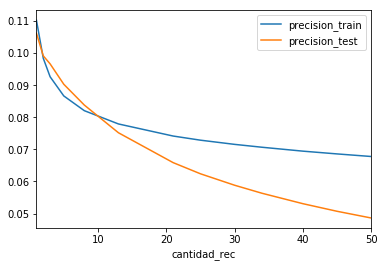

In [20]:
predicciones_n.plot(x='cantidad_rec', y=['precision_train','precision_test'])


In [21]:
# Calculos del MAP
metrics_ranking_test.meanAveragePrecision()

TypeError: 'float' object is not callable

In [ ]:
#metrics_pre.confusionMatrix()
predictionAndLabels_test.schema

## Salvando el modelo en el bucket

In [ ]:
# Save and load model

#model.write().overwrite().save("gs://pry_spsa/models/my_als_model")
model.save("gs://pry_spsa/models/my_als_model")
#sameModel = MatrixFactorizationModel.load(sc, "gs://pry_spsa/models/my_als_model")

## Loading the saved model

In [ ]:
# Generate top 10 movie recommendations for a specified set of users
#users_148 = ratings_train.select(als.getUserCol()).distinct().limit(3)
#userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of items
#items = ratings_train.select(als.getItemCol()).distinct().limit(3)
#itemsSubSetRecs = model.recommendForItemSubset(items, 10)
# TF_IDF para sistemas de recomendación
#https://towardsdatascience.com/recommender-engine-under-the-hood-7869d5eab072  

#userSubsetRecs

In [ ]:

#https://medium.com/google-cloud/recommendation-systems-with-spark-on-google-dataproc-bbb276c0dafd
#https://medium.com/datos-y-ciencia/intro-als-pyspark-7de7f3ba3b0a
#
#https://stackoverflow.com/questions/37260902/tuning-parameters-for-implicit-pyspark-ml-als-matrix-factorization-model-through

In [ ]:
#https://medium.com/datos-y-ciencia/exploraci%C3%B3n-y-pre-procesamiento-de-datos-credit-card-pyspark-d5afa9d30320
#https://medium.com/datos-y-ciencia/pyspark-integrando-mlflow-tracking-models-dfc15e52024d
#https://medium.com/datos-y-ciencia/intro-als-pyspark-7de7f3ba3b0a
#https://stats.stackexchange.com/questions/90779/area-under-the-roc-curve-or-area-under-the-pr-curve-for-imbalanced-data?rq=1
#http://spark.apache.org/docs/2.0.0/api/python/_modules/pyspark/ml/evaluation.html
#https://spark.apache.org/docs/latest/ml-tuning.html
#https://spark.apache.org/docs/latest/ml-pipeline.html
#https://spark.apache.org/docs/latest/ml-collaborative-filtering.html#explicit-vs-implicit-feedback
#https://creativedata.atlassian.net/wiki/spaces/SAP/pages/83237142/Pyspark+-+Tutorial+based+on+Titanic+Dataset
#https://stackoverflow.com/questions/39529012/pyspark-get-all-parameters-of-models-created-with-paramgridbuilder
#https://stackoverflow.com/questions/38874546/spark-crossvalidatormodel-access-other-models-than-the-bestmodel
#https://stackoverflow.com/questions/53600615/cross-validation-metrics-with-pyspark
#https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark
